In [83]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from custom import weather

matplotlib.rcParams['font.family'] = ['PingFang HK']
def rmax(maxrow: int=50):
    pd.set_option('display.max_rows', maxrow)
def cmax(maxcol: int=50):
    pd.set_option('display.max_columns', maxcol)

# %load_ext autoreload
# %autoreload 2

## Load from saved station dataframe

In [84]:
df = pd.read_csv('all_station_20201126.csv')
## remove stations with data less than 1 year
df = df[df.data_duration>=12]

In [104]:
df[df.stn_name=='泰平']

stn_code stn_name  altitude   Longitude   Latitude city  \
36   C0A550       泰平     422.0  121.823711  24.971197  新北市   

                     address data_start_date  stn_end_date comment  \
36  雙溪區泰平里8鄰大平路43號(泰平國小分校附近)      1987/05/01           NaN     NaN   

   orig_stn_code  new_stn_code data_start_date2  data_duration data_duration2  \
36           NaN           NaN       2015-01-01             70         5年10個月   

              data_period  
36  1987/05/01-2020/11/26

## Load cleaned weather data

In [85]:
df_w = pd.read_pickle('weather_all_cleaned.bz2')
# move index to columns for easier grouping
df_w.reset_index(inplace=True)
df_w['month'] = df_w.date.dt.month
df_w['year'] = df_w.date.dt.year

## Keep only stations with cleaned weather records data

In [86]:
# only keep weather stations without too many missing data (as filtered in the cleaned dataset)
df = df[df.stn_code.isin(df_w.stn_code.unique())]
df.shape

(446, 16)

## Make wind dir bins

In [87]:
#direction 0 means no wind, not direction, north is 360
df_w['WD'].replace({0: np.nan}, inplace=True)

In [88]:
bin_width = 10
nbin = 360//bin_width

# make Wind direction binning
bin_edge = np.linspace(bin_width//2, 360+bin_width//2, nbin+1)
bin_label = list(range(bin_width,360+bin_width,bin_width)) ## label is at the center of the bin (label:10 for edge[5,15])
print(bin_edge, bin_label)

## shift the 1-4 degree to 361-364 for better binning representation 
df_w['WD_shifted'] = df_w['WD']
df_w.loc[df_w.WD<bin_width//2, 'WD_shifted'] = df_w.WD+360

df_w[f'WD_bin_{bin_width}'] = pd.cut(df_w.WD_shifted, bins=bin_edge, labels=bin_label)

[  5.  15.  25.  35.  45.  55.  65.  75.  85.  95. 105. 115. 125. 135.
 145. 155. 165. 175. 185. 195. 205. 215. 225. 235. 245. 255. 265. 275.
 285. 295. 305. 315. 325. 335. 345. 355. 365.] [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360]


In [7]:
# nbin = 36
# bin_start = (360/nbin)

# # make Wind direction binning
# bin10_edge = np.linspace(5, 365, 37)
# bin10_label = list(range(10,370,10)) ## label is at the center of the bin (label:10 for edge[5,15])
# print(bin10_edge, bin10_label)
# ## shift the 1-4 degree to 361-364 for better binning representation 
# df_w['WD_shifted'] = df_w['WD']
# df_w.loc[df_w.WD<5, 'WD_shifted'] = df_w.WD+360

# df_w['WD_bin10'] = pd.cut(df_w.WD_shifted, bins=bin10_edge, labels=bin10_label)

### test different cmap and levels

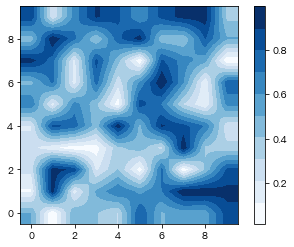

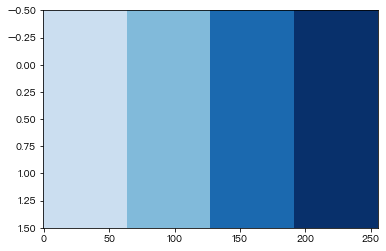

In [22]:
cmap = matplotlib.cm.get_cmap('Blues', 10)
cmap4 = [cmap(i) for i in [2,4,7,9]]
chex = [matplotlib.colors.rgb2hex(i) for i in cmap4]

mat = np.random.random((10,10))
plt.imshow(mat, origin="lower", cmap=cmap, interpolation='bilinear')
plt.colorbar()
plt.show()

cmap_mod=matplotlib.colors.ListedColormap(cmap4)
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.imshow(gradient, aspect='auto', cmap=cmap_mod)
plt.show()

## Function plot wind rose

In [117]:
def plot_wind_rose(df_temp, wd_bin_col, ws_col, ws_bin_edges=None, cmap='Blues', ax=None):
        
    ## make wind speed binning
    if ws_bin_edges is None:
        _, ws_bin_edges = pd.qcut(df_temp.WS, 4, retbins=True)
    df_temp['WS_bin'] = pd.cut(df_temp[ws_col], ws_bin_edges)
    df_temp['WS_bin_code'] = df_temp['WS_bin'].astype('category').cat.codes
    ws_labels = [f'{ws_bin_edges[i]}-{ws_bin_edges[i+1]} m/s' for i in range(len(ws_bin_edges)-1)]

    ## make colormaps
    cmap = matplotlib.cm.get_cmap(cmap, 10)
    cmap4 = [cmap(i) for i in [2,4,6,8]]
    ## bar width
    nbin = len(df_temp[wd_bin_col].cat.categories)
    width = (2*np.pi) / nbin
    ## polar coord of the bar (center angles in radian)
    theta = np.linspace((2*np.pi)/nbin, 2*np.pi, nbin, endpoint=True)
#     print(np.degrees(theta))
    
    ## stacked polar bar plot
    if ax is None:
        ax = plt.subplot(111,polar=True)
    bottom=0
    for b in np.sort(df_temp.WS_bin_code.unique()):
        if b<0: ## for No wind situation WS=nan
            continue
        ws_bin = df_temp[df_temp.WS_bin_code==b]
        radii = ws_bin[wd_bin_col].value_counts(sort=False)
        bars = ax.bar(theta, radii, width=width, bottom=bottom, align='center',
            edgecolor = 'gray', linewidth=0, color=cmap4[b], label=ws_labels[b])
        bottom+=radii
        
    # set starting from 12o'clock and clockwise
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    # hide grid, spine and yticks
    ax.grid(alpha=0.3)
    ax.spines['polar'].set_visible(False)
    ax.set_yticks([])
#     ax.set_xticks([])
    # set the angle label
    xticks = ax.get_xticks()
    ax.set_xticks(xticks)
    # ax.set_xticks([0,np.pi/2,np.pi,np.pi*3/2])
#     ax.set_xticklabels(['N','', 'E','', 'S','', 'W',''])
    ax.set_xticklabels("")

    return ax

In [114]:
code_temp = 'C0A550'
m = 5

df_temp = df_w[df_w.stn_code==code_temp].reset_index(drop=True)
_, WS_bin_edges = pd.qcut(df_temp.WS, 4, retbins=True, duplicates='drop')

In [49]:
df_temp = df_temp[df_temp.month==m].reset_index(drop=True)

C0A550 [0.  0.1 0.2 2.5]


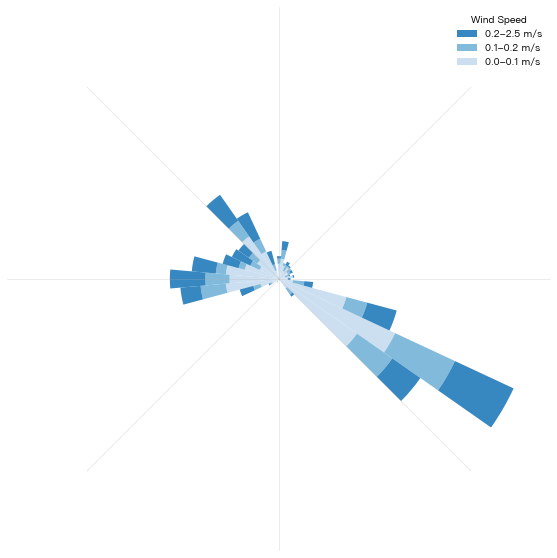

CPU times: user 3.63 s, sys: 296 ms, total: 3.93 s
Wall time: 3.7 s


In [116]:
%%time
fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw=dict(polar=True))
plot_wind_rose(df_temp, 'WD_bin_10', 'WS', ws_bin_edges=WS_bin_edges, cmap='Blues', ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Wind Speed', loc='upper right', frameon=False)
plt.show()

### plot and save wind directon plot for all stations

In [25]:
### plot the average wind and wind gust

# for code in tqdm(codes_plot):

#     stn_name = df[df.iloc[:,0]==code].iloc[0,1]
#     print(f'plotting {stn_name}')
    
#     temp = df_w.loc[code]
#     temp['month'] = temp.index.month.astype('category')
#     temp['year'] = temp.index.year.astype('category')

#     fig, axes = plt.subplots(figsize=(12,15), ncols=3, nrows=4, subplot_kw=dict(polar=True))
# #     fig.suptitle(stn_name, fontsize=18, y=0.98)
#     bw=10
#     y_max=0
#     for m, ax in zip(np.r_[12,1:12], axes.flat):
#         temp_m = temp[temp.month==m]
#         wind = temp_m.WD
#         windG = temp_m.WDGust

#         ## Get the max wind gust speed and dir in full period (all years)
#         idx = temp_m.WSGust.idxmax()
#         G_max = temp_m.loc[idx, 'WSGust']
#         G_dir = temp_m.loc[idx, 'WDGust']
#     # #     counts, bins = np.histogram(temp_m.loc[idx.dropna()].WDGust, bins=(360//bw), range=[0,360])
#     #     ## 當月最大風速 "最常" 出現在那個方向. 
#     #     G_dir = bins[np.argmax(counts)]

#         radi_max = weather.plot_wind_gust(wind, windG, G_dir, G_max, bin_degree=10, ax=ax)
#         y_max = radi_max if (radi_max>y_max) else y_max
#         monthname = datetime.strptime(str(m), "%m").strftime("%B")
#         ax.set_title(monthname, x=0.1)
    
#     for ax in axes.flat:  ## set all subplot with the same maximum
#         ax.set_ylim(0,y_max)
        
#     plt.tight_layout()
#     plt.savefig(f'resources/{code}.png')
#     plt.close(fig)

In [ ]:
temp = df_w.loc[df_w.stn_code=='C0E540']
_, ws_bin_edges = pd.qcut(temp.WS, 4, retbins=True)
# print(ws_bin_edges)
for m in np.r_[12,1:12]:
    temp_m = temp[temp.month==m]
#     print(temp_m['WS'].unique())
#     temp_m['WS_bin'] = pd.cut(temp_m['WS'], ws_bin_edges)
#     print(temp_m['WS_bin'].unique())
#     temp_m['WS_bin_code'] = temp_m['WS_bin'].astype('category').cat.codes
#     ws_labels = [f'{ws_bin_edges[i]}-{ws_bin_edges[i+1]} m/s' for i in range(len(ws_bin_edges)-1)]
#     print(ws_labels)
    ax = plot_wind_rose(temp_m, 'WD_bin_10', 'WS', ws_bin_edges=ws_bin_edges)
    handles, labels = ax.get_legend_handles_labels()
    print(len(labels))
    print(labels)
    ax.cla()

In [118]:
### plot the average wind with colorcoded ws(by WD)
from matplotlib import cm
pd.options.mode.chained_assignment = None 

icon=matplotlib.image.imread('resources/north_icon_s.png')

def create_windrose_allstn(df_stn, df_weather, col_wd, col_ws, save=False, cmap='Blues'):
    ''' 
    df_weather is the dataframe of full weather records, need to have 'month' column
    df, is the df of station information
    '''
    plt.rcParams['font.sans-serif'] = ['PingFang HK']
    dpi = matplotlib.rcParams['figure.dpi']
    fig_w = 640
    fig_h = 900
    ncol = 3
    nrow = 4
    
    for i, row in df_stn.iterrows():
#         print(f'plotting {row.stn_name}')
        temp = df_weather.loc[df_weather.stn_code==row.stn_code]
        ## get wind speed binning edges of this station
        _, ws_bin_edges = pd.qcut(temp.WS, 4, retbins=True, duplicates='drop')
                
        ## get the max value over 12 months for plot scaling 
        wdcount_max = temp.groupby(['month',col_wd]).date.count().max()
        
        ## set figure parameters
        fig, axes = plt.subplots(figsize=(fig_w/dpi,fig_h/dpi), ncols=ncol, nrows=nrow, subplot_kw=dict(polar=True))
        fig.subplots_adjust(bottom=0, top=0.85, left=0, right=1, wspace=0., hspace=0.)
        title = f'{row.stn_name}, {row.city}, Alt:{round(row.altitude)}m'
        fig.suptitle(title, fontsize=20, x=0.02, y=0.95, ha='left', va='top' )

        ## iterate through 12 months
        print(row.stn_name, ws_bin_edges)
        print(temp.WS.min(), temp.WS.max())
        for m, ax in zip(np.r_[12,1:12], axes.flat):
            temp_m = temp[temp.month==m]
            
            plot_wind_rose(temp_m, col_wd, col_ws, ws_bin_edges=ws_bin_edges, cmap=cmap, ax=ax)
            ## set normalize the max count to each station (whole year)
            ax.set_ylim(0,wdcount_max)
            ## print month on each rose plot
            monthname = datetime.strptime(str(m), "%m").strftime("%B")
            ax.set_title(monthname, x=0.1, y=0.95)
    
        ## add colorbar legend
        handles, labels = axes[0][0].get_legend_handles_labels()
        fig.legend(handles[::-1], labels[::-1], loc='upper right', bbox_to_anchor=(0.9, 0.98), 
                   title='Wind Speed', frameon=False, ncol=1)

        ## add north icon axe
        fig.figimage(icon, fig_w-230 , fig_h-90)
        if save:
#             plt.savefig(f'resources/{row.stn_code}.png', facecolor='white', bbox_inches = 'tight', pad_inches = 0.1)
            plt.close(fig)

板橋
0.3 8.4
[0.3 1.2 1.8 2.6 8.4]
板橋 [0.3 1.2 1.8 2.6 8.4]
0.3 8.4
淡水
0.0 6.8
[0.  1.2 1.5 2.  6.8]
淡水 [0.  1.2 1.5 2.  6.8]
0.0 6.8
鞍部
0.5 12.1
[ 0.5  1.7  2.4  3.3 12.1]
鞍部 [ 0.5  1.7  2.4  3.3 12.1]
0.5 12.1
臺北
0.4 9.6
[0.4 1.4 2.1 3.2 9.6]
臺北 [0.4 1.4 2.1 3.2 9.6]
0.4 9.6
竹子湖
0.1 7.4
[0.1 0.9 1.4 2.6 7.4]
竹子湖 [0.1 0.9 1.4 2.6 7.4]
0.1 7.4
基隆
0.7 14.3
[ 0.7  2.   2.6  3.6 14.3]
基隆 [ 0.7  2.   2.6  3.6 14.3]
0.7 14.3
彭佳嶼
1.0 29.7
[ 1.   5.3  7.   8.8 29.7]
彭佳嶼 [ 1.   5.3  7.   8.8 29.7]
1.0 29.7
花蓮
0.6 13.5
[ 0.6  2.2  2.7  3.3 13.5]
花蓮 [ 0.6  2.2  2.7  3.3 13.5]
0.6 13.5
新屋
1.0 16.1
[ 1.   2.8  4.9  7.4 16.1]
新屋 [ 1.   2.8  4.9  7.4 16.1]
1.0 16.1
蘇澳
0.5 16.3
[ 0.5  2.   2.4  3.  16.3]
蘇澳 [ 0.5  2.   2.4  3.  16.3]
0.5 16.3
宜蘭
0.6 14.2
[ 0.6  1.5  1.8  2.2 14.2]
宜蘭 [ 0.6  1.5  1.8  2.2 14.2]
0.6 14.2
金門
0.7 11.2
[ 0.7  2.2  3.   3.8 11.2]
金門 [ 0.7  2.2  3.   3.8 11.2]
0.7 11.2
東吉島
1.2 23.7
[ 1.2  4.2  6.7 10.4 23.7]
東吉島 [ 1.2  4.2  6.7 10.4 23.7]
1.2 23.7
澎湖
0.9 11.5
[ 0.9  2.3  3.6 

/Users/qzt/miniconda3/envs/data/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


大武 [0.7 1.7 2.3 3.2 8.8]
0.7 8.8
玉山
0.8 15.3
[ 0.8  3.3  4.2  5.3 15.3]
玉山 [ 0.8  3.3  4.2  5.3 15.3]
0.8 15.3
新竹
0.3 7.0
[0.3 1.2 1.6 2.3 7. ]
新竹 [0.3 1.2 1.6 2.3 7. ]
0.3 7.0
恆春
0.7 12.9
[ 0.7  1.9  2.8  4.3 12.9]
恆春 [ 0.7  1.9  2.8  4.3 12.9]
0.7 12.9
成功
0.8 8.7
[0.8 2.  2.7 3.9 8.7]
成功 [0.8 2.  2.7 3.9 8.7]
0.8 8.7
蘭嶼
1.4 22.8
[ 1.4  4.8  6.1  8.3 22.8]
蘭嶼 [ 1.4  4.8  6.1  8.3 22.8]
1.4 22.8
日月潭
0.3 5.0
[0.3 1.  1.2 1.3 5. ]
日月潭 [0.3 1.  1.2 1.3 5. ]
0.3 5.0
臺東
0.5 11.7
[ 0.5  1.2  1.6  2.1 11.7]
臺東 [ 0.5  1.2  1.6  2.1 11.7]
0.5 11.7
梧棲
1.2 16.2
[ 1.2  2.8  3.9  5.5 16.2]
梧棲 [ 1.2  2.8  3.9  5.5 16.2]
1.2 16.2
馬祖
0.8 12.5
[ 0.8  2.4  3.4  4.7 12.5]
馬祖 [ 0.8  2.4  3.4  4.7 12.5]
0.8 12.5
山佳
0.1 7.7
[0.1 0.7 1.3 2.9 7.7]
山佳 [0.1 0.7 1.3 2.9 7.7]
0.1 7.7
坪林
0.1 9.0
[0.1 0.5 0.9 1.6 9. ]
坪林 [0.1 0.5 0.9 1.6 9. ]
0.1 9.0
四堵
0.0 3.6
[0.  0.1 0.3 0.5 3.6]
四堵 [0.  0.1 0.3 0.5 3.6]
0.0 3.6
泰平
0.0 2.5


ValueError: Bin edges must be unique: array([0. , 0. , 0.1, 0.2, 2.5]).
You can drop duplicate edges by setting the 'duplicates' kwarg

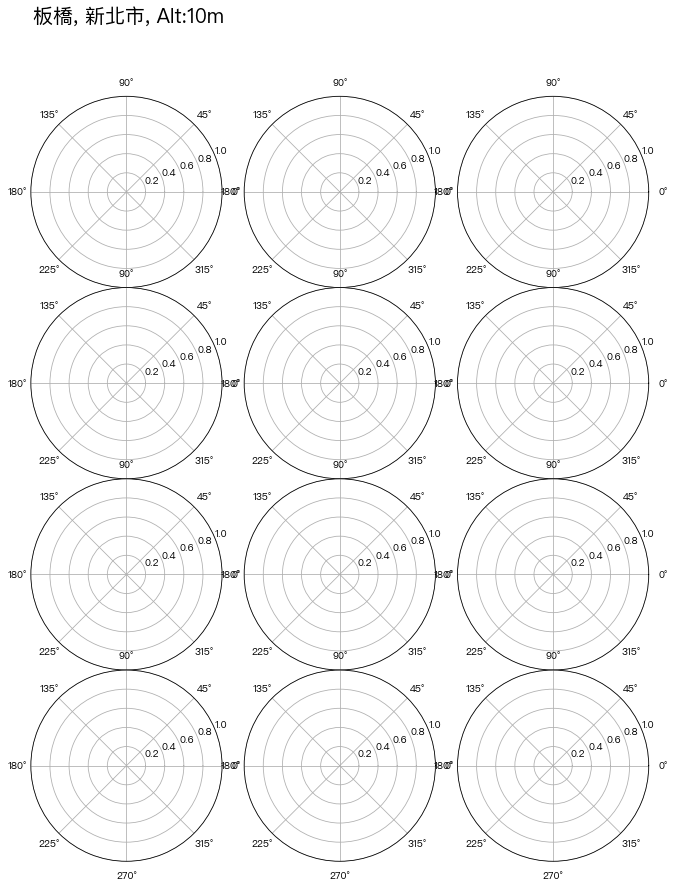

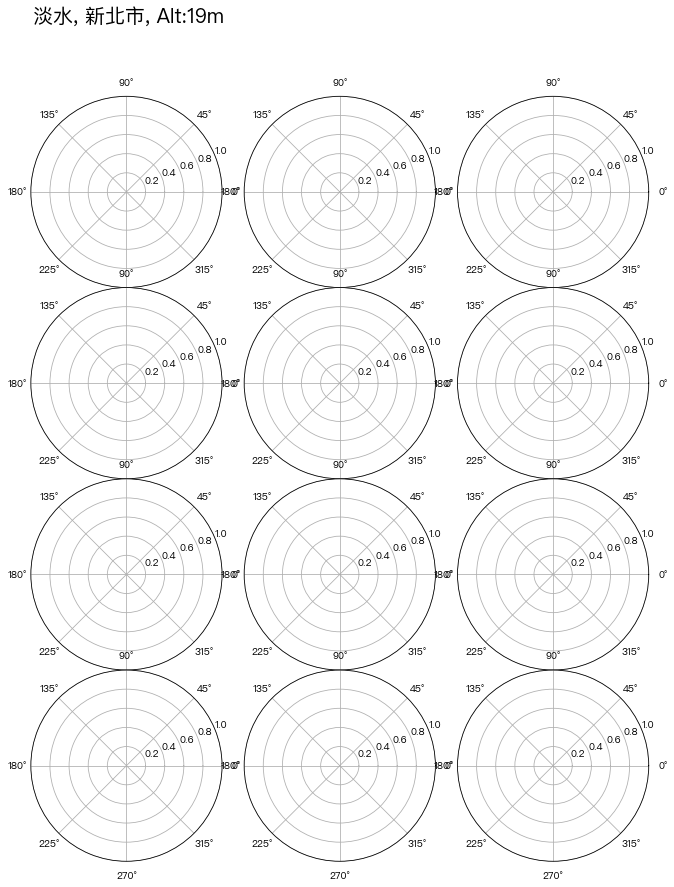

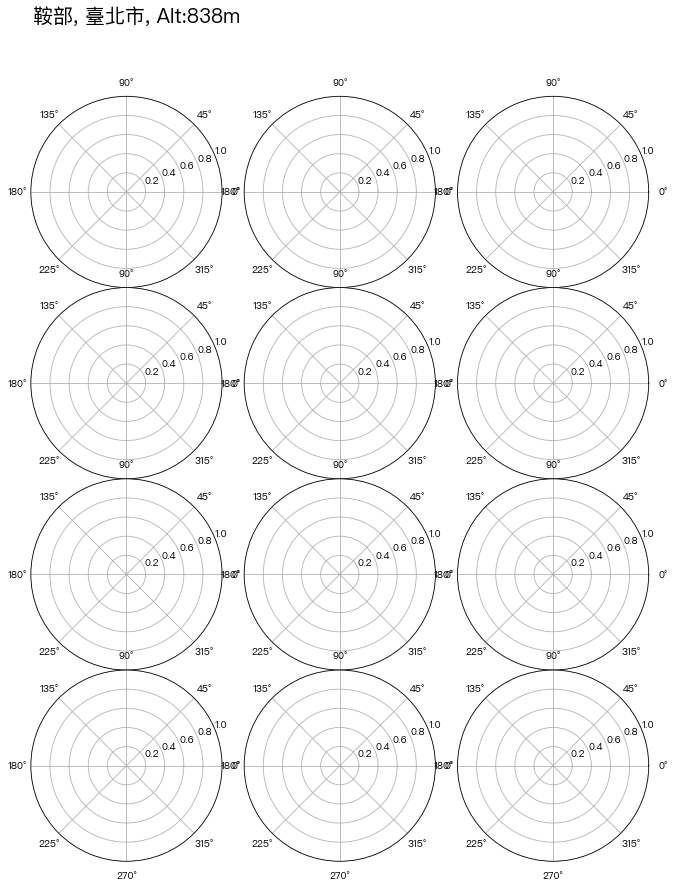

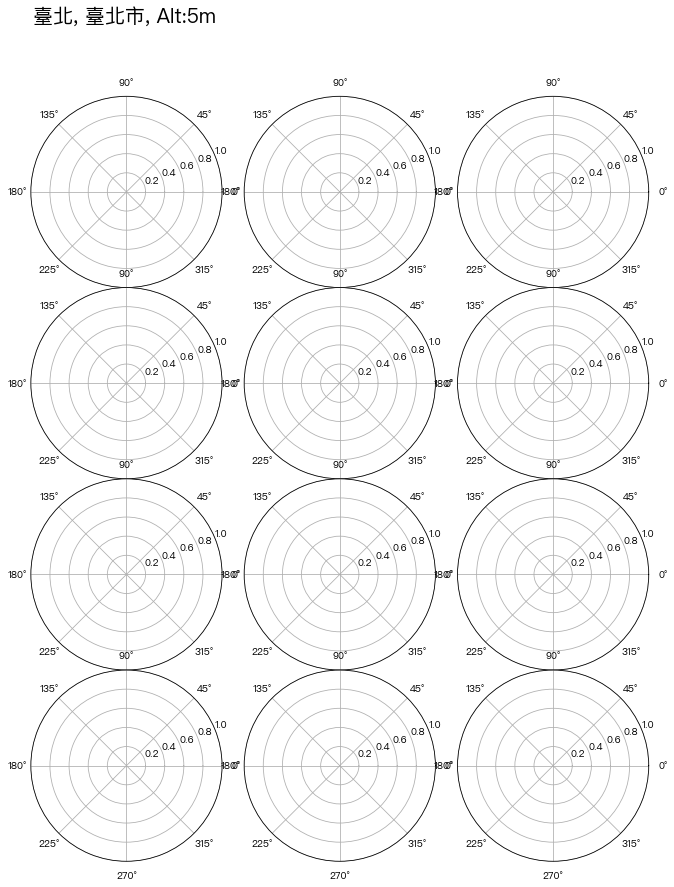

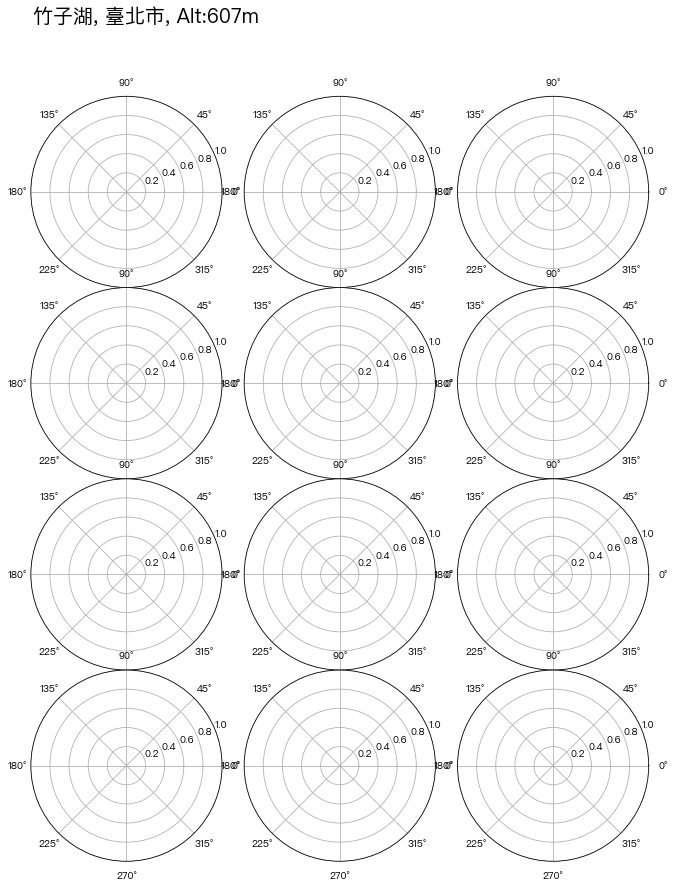

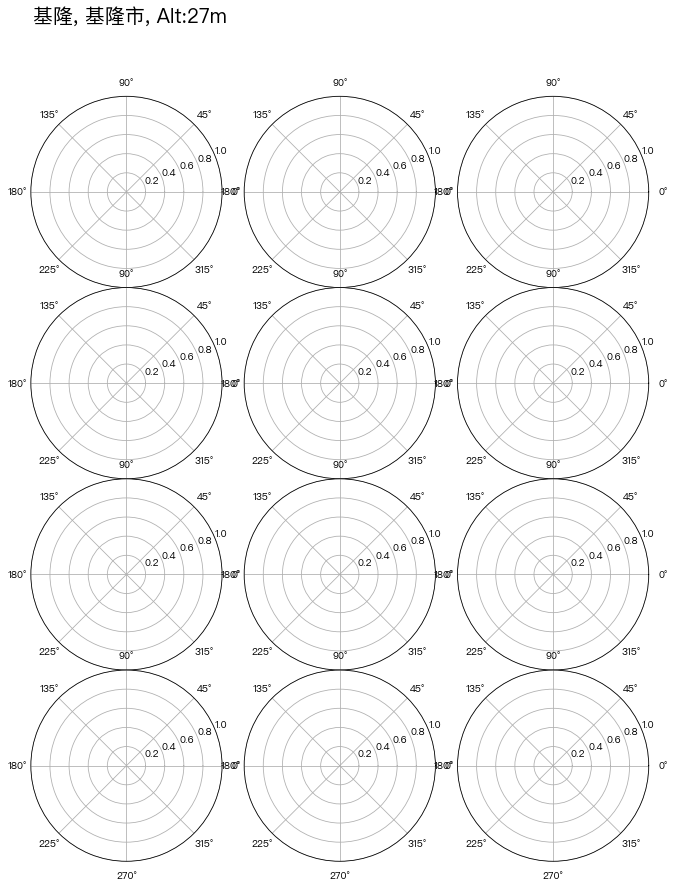

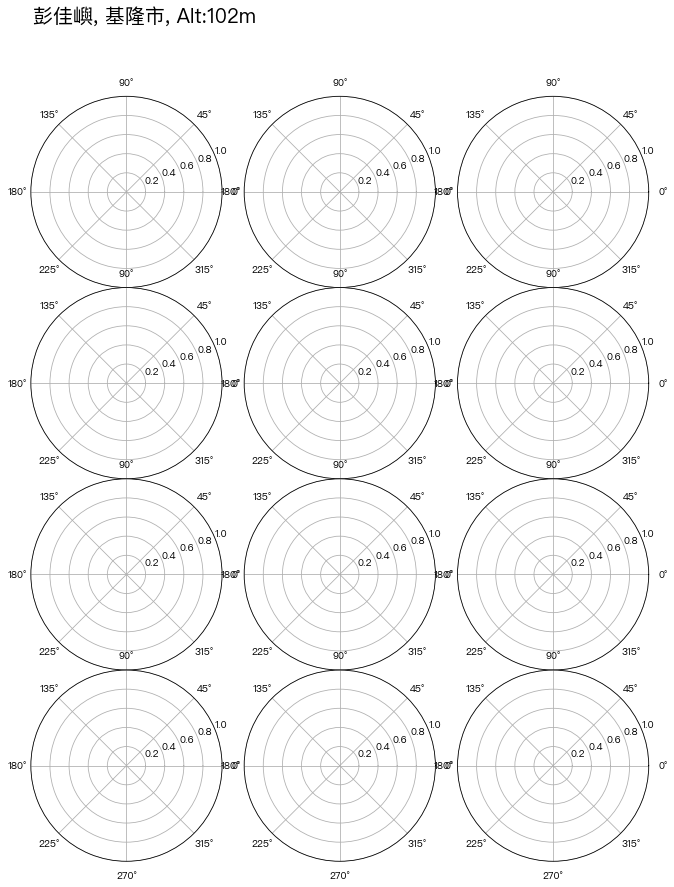

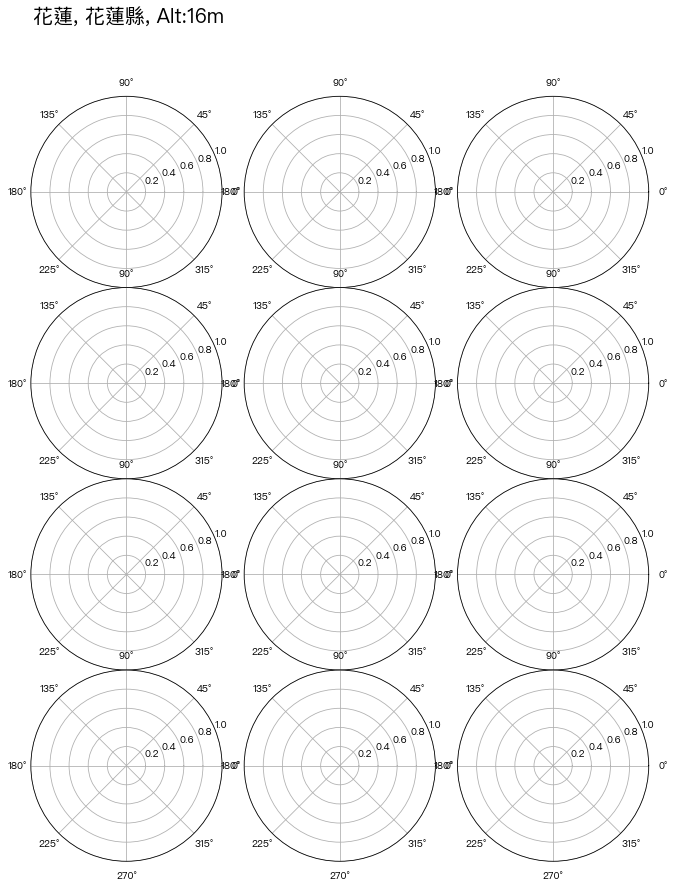

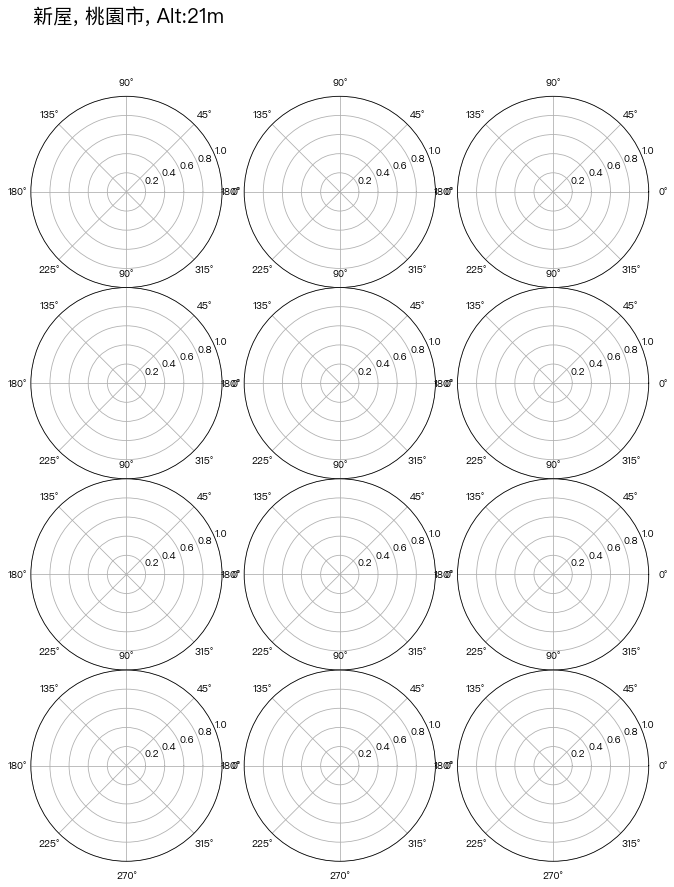

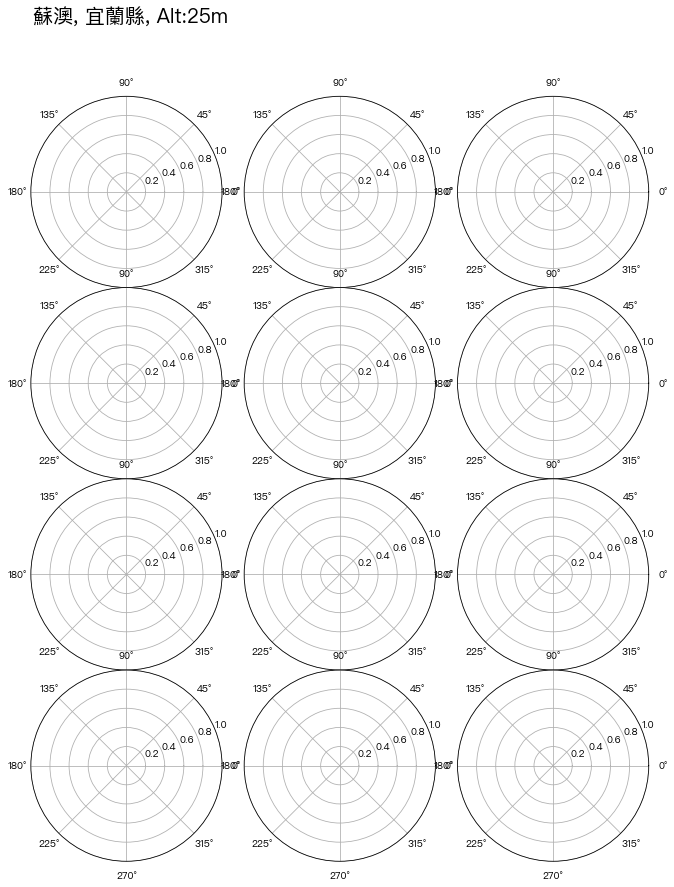

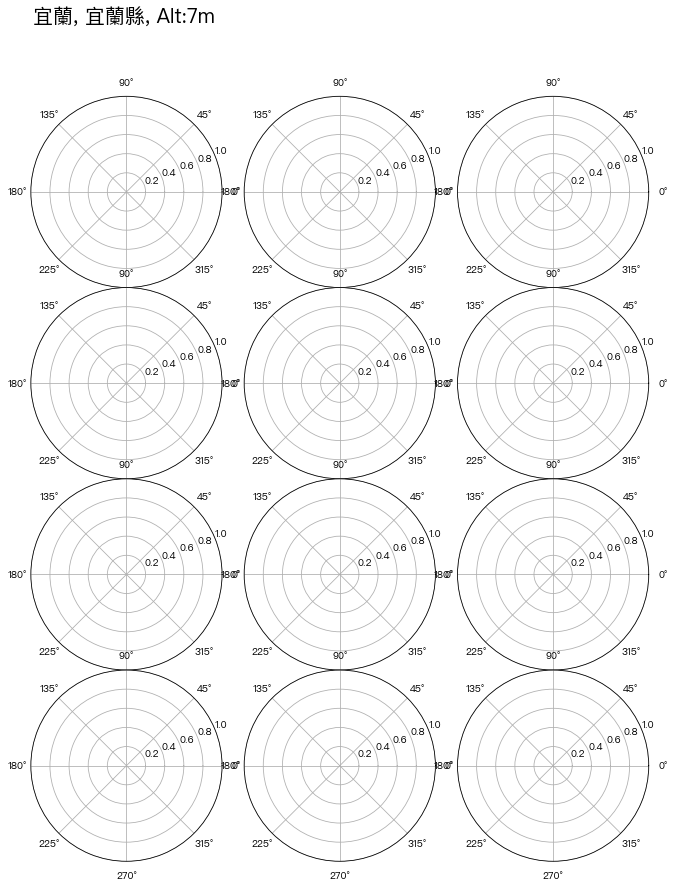

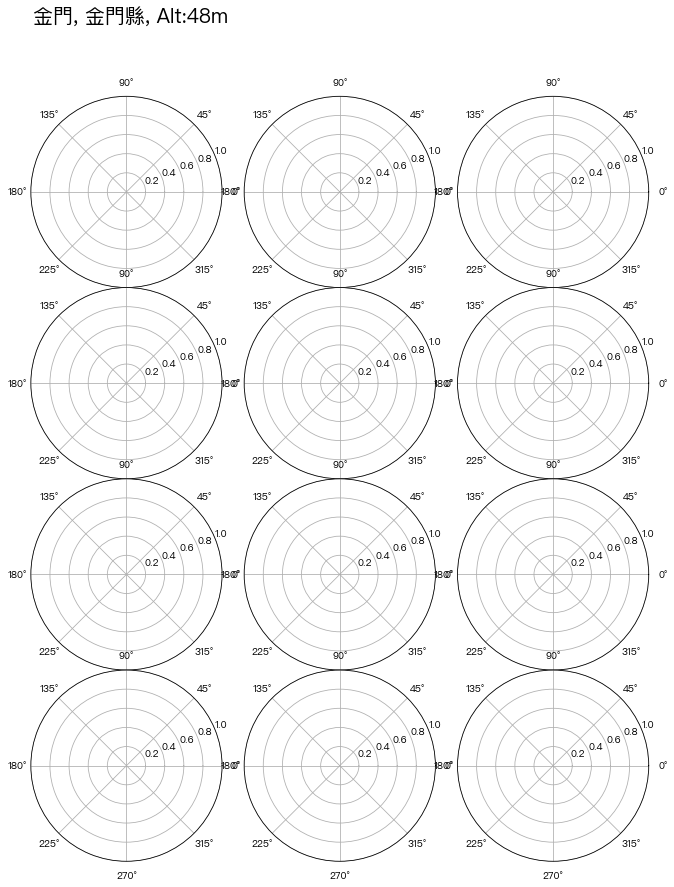

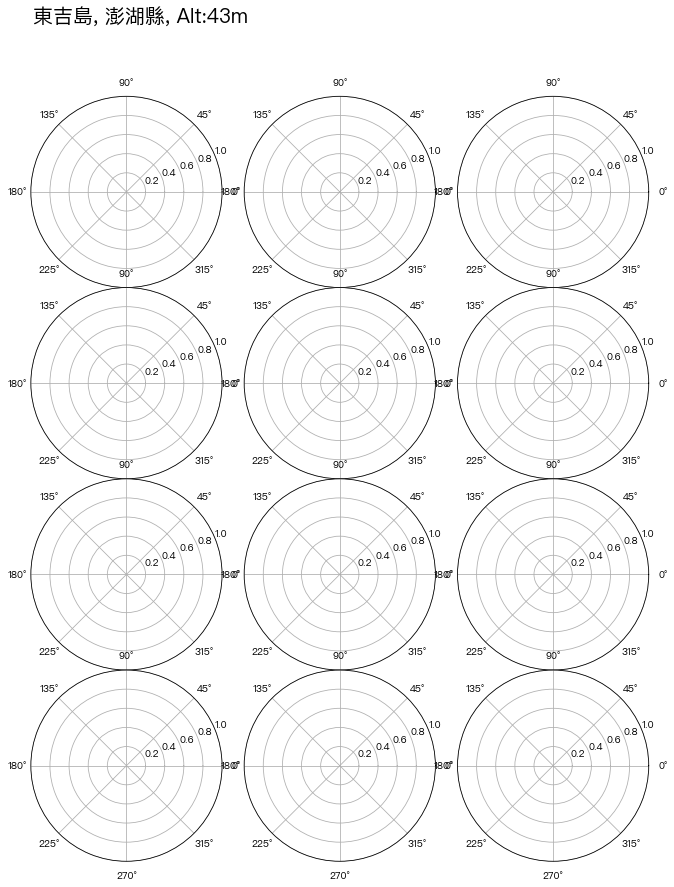

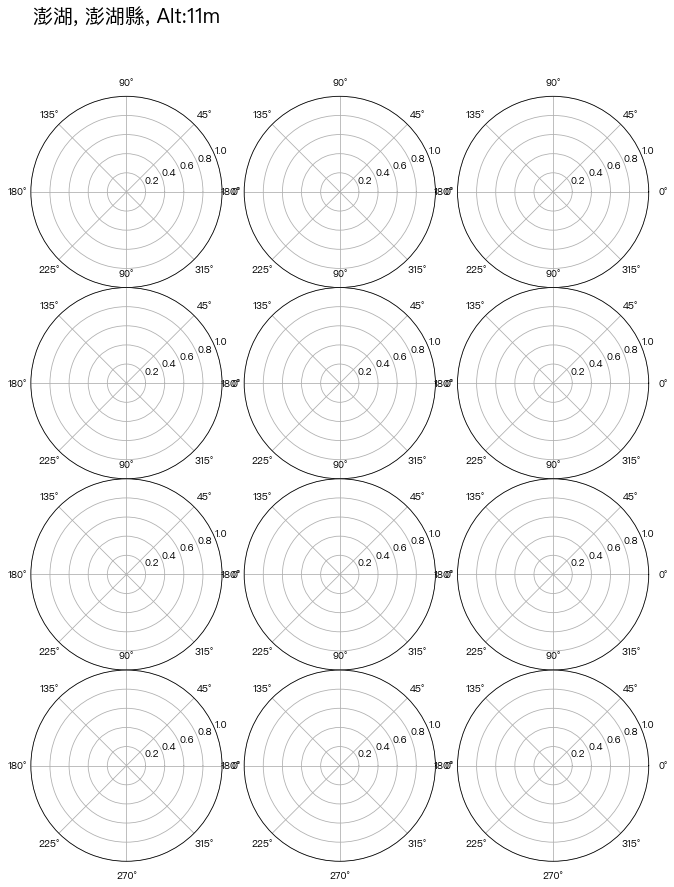

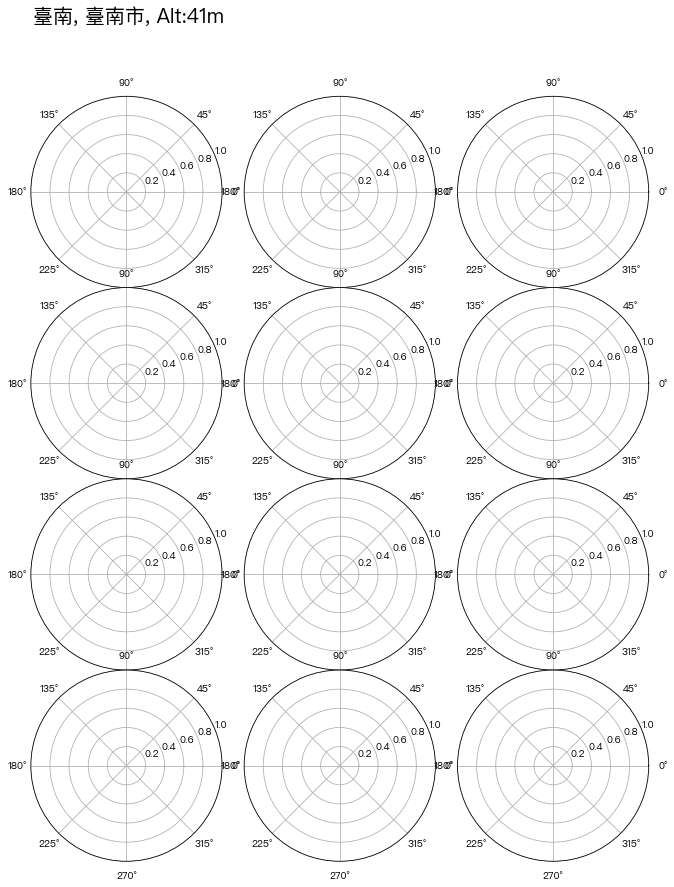

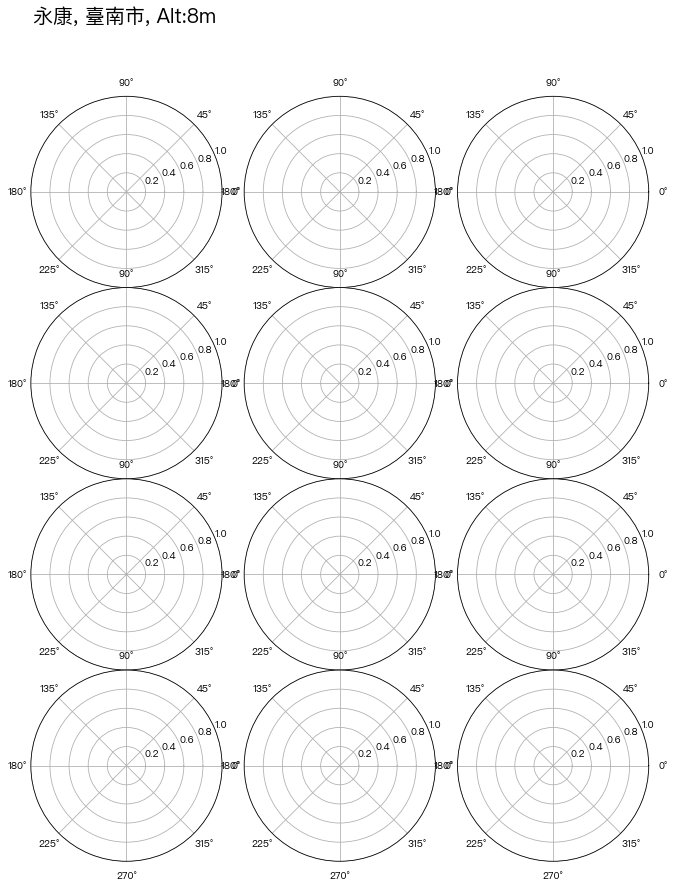

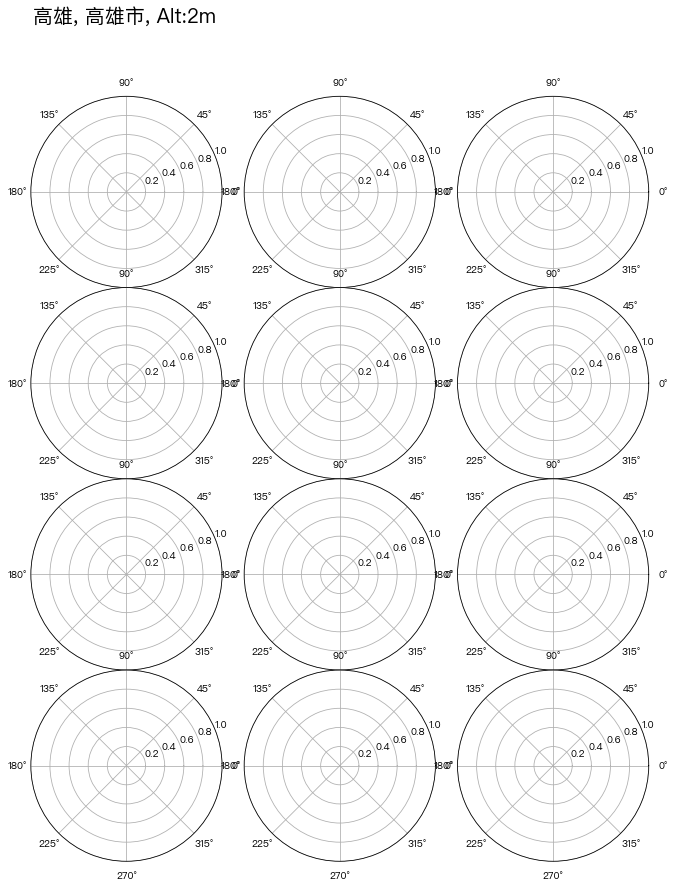

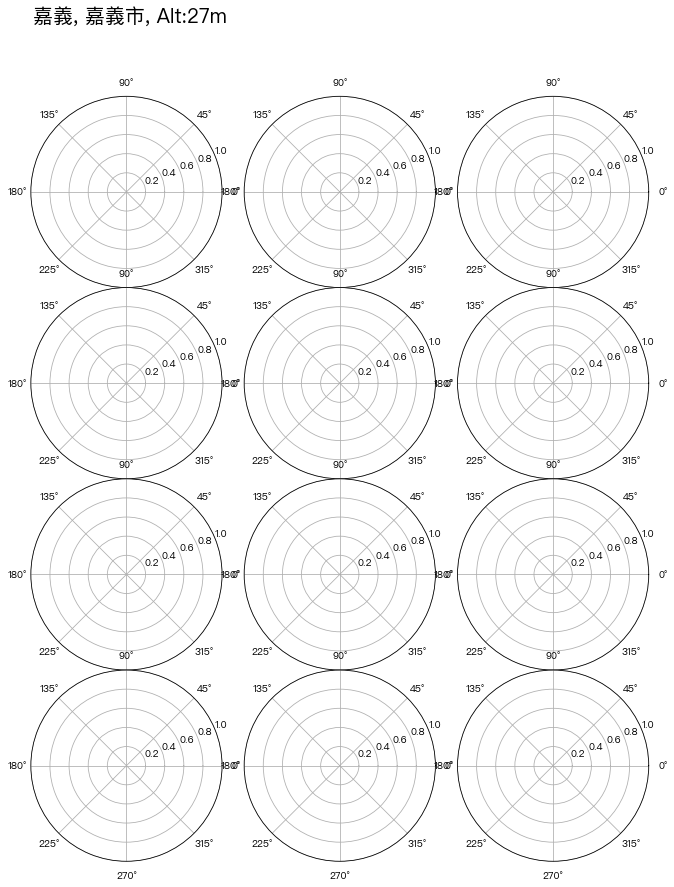

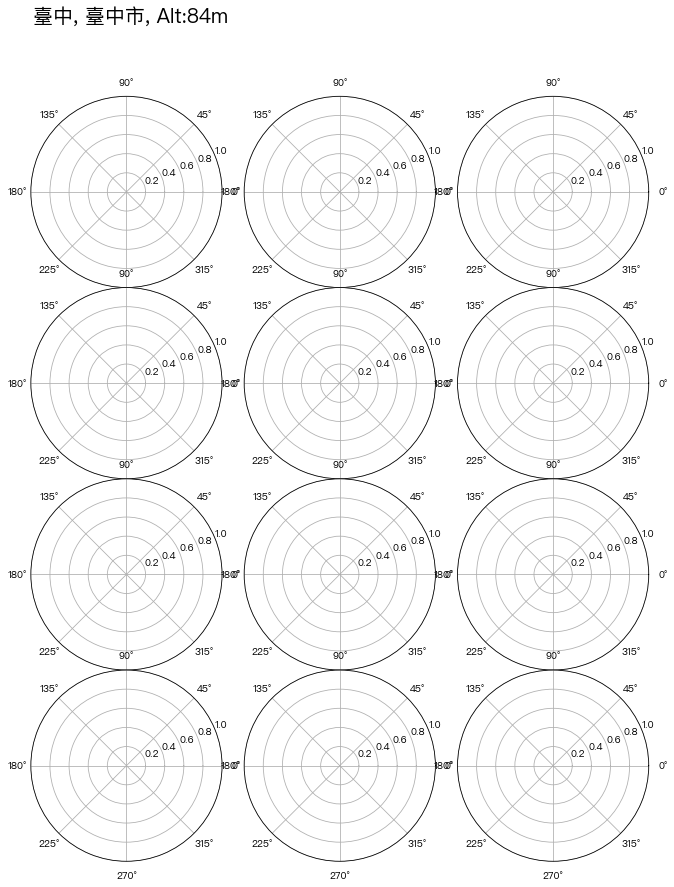

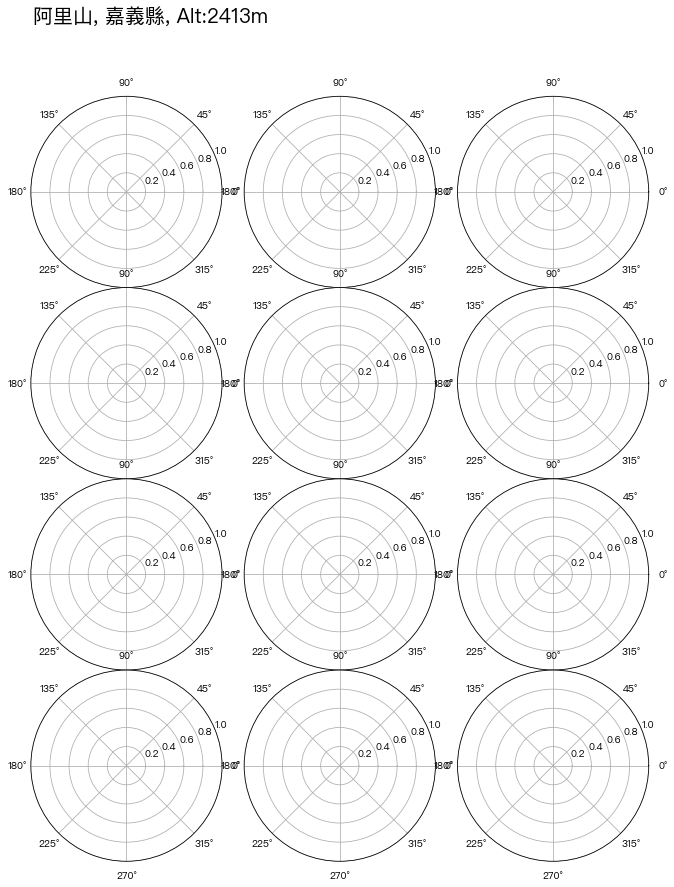

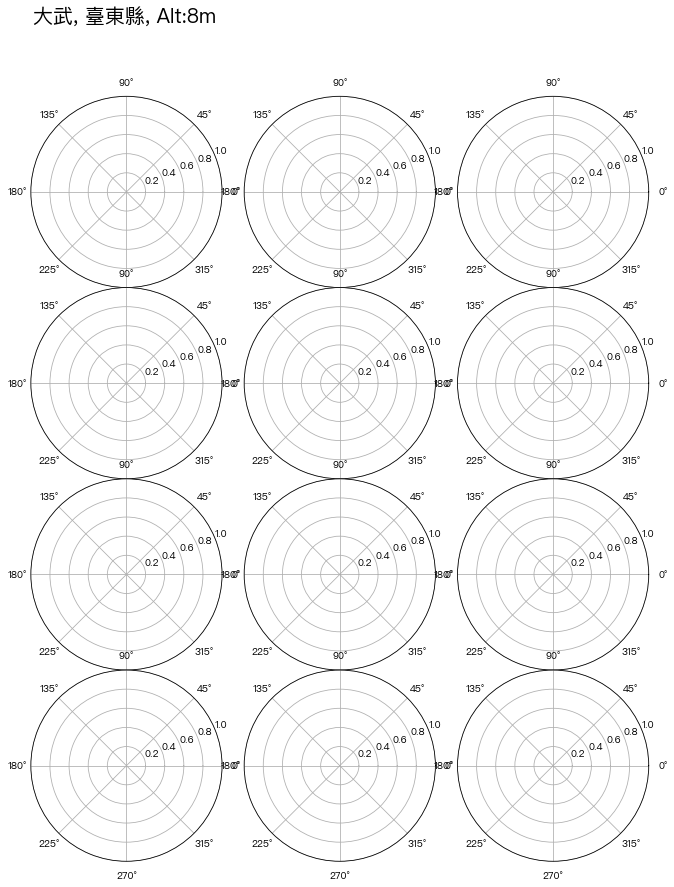

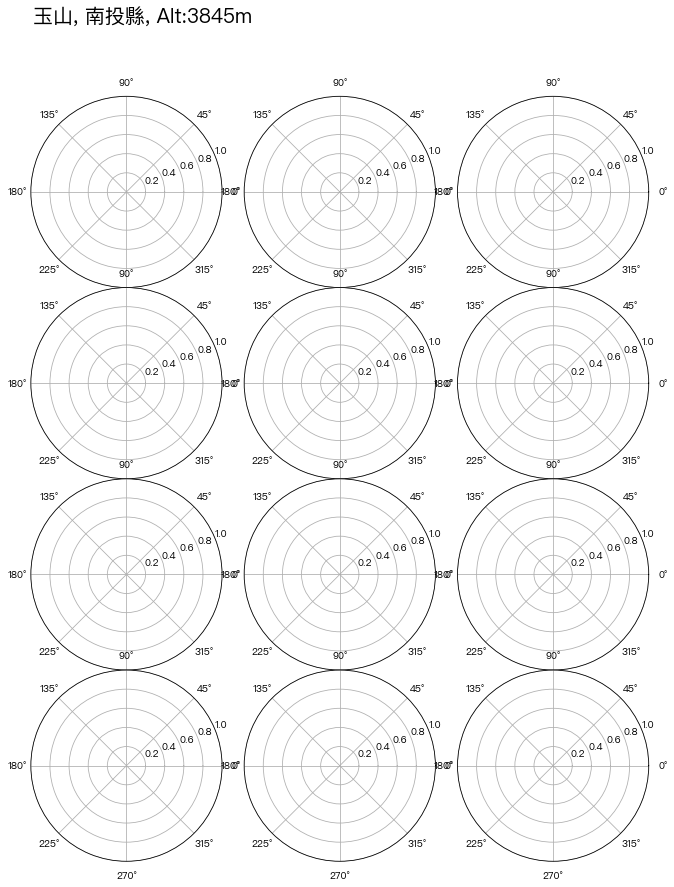

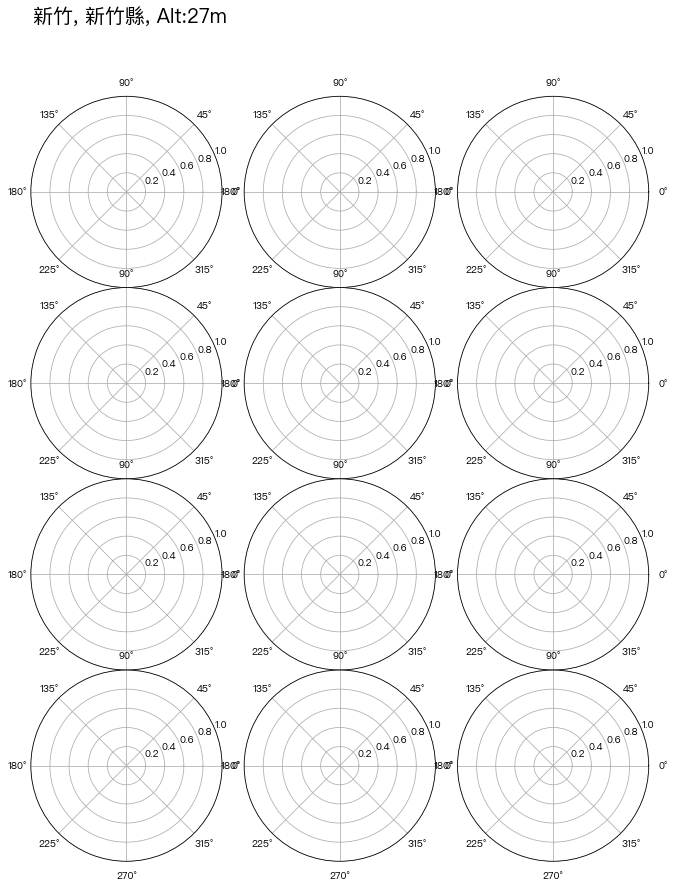

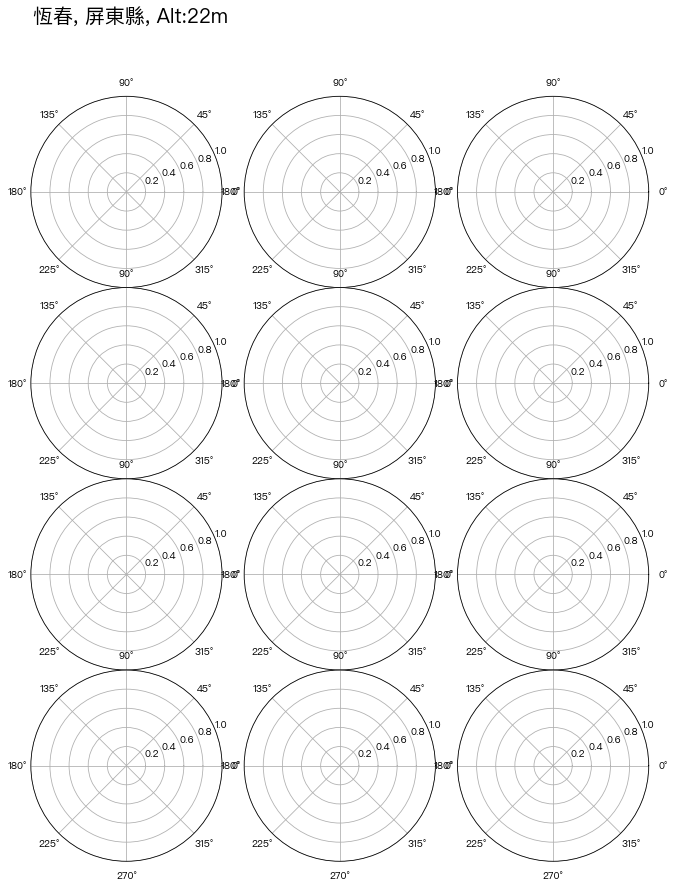

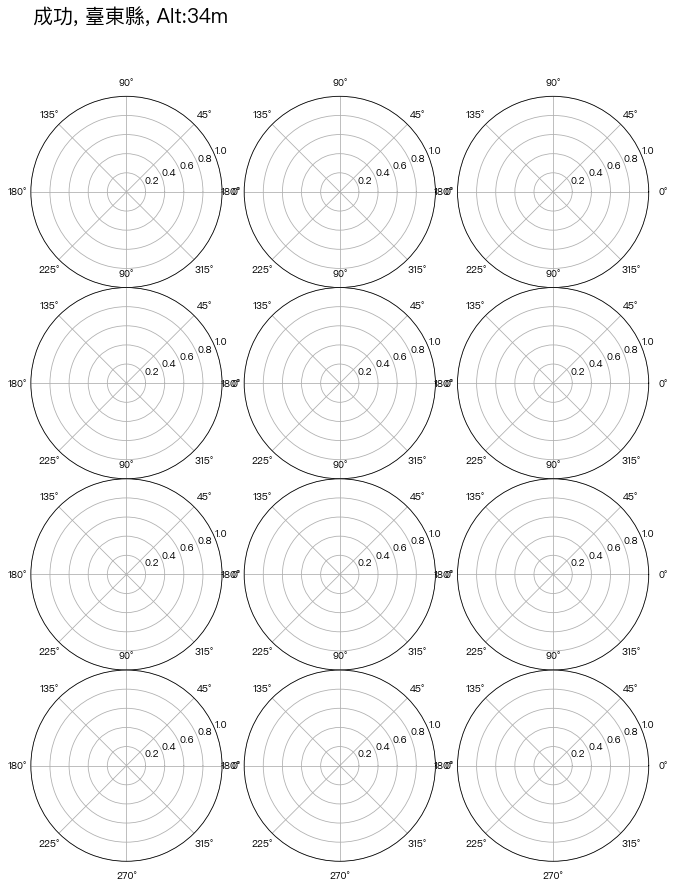

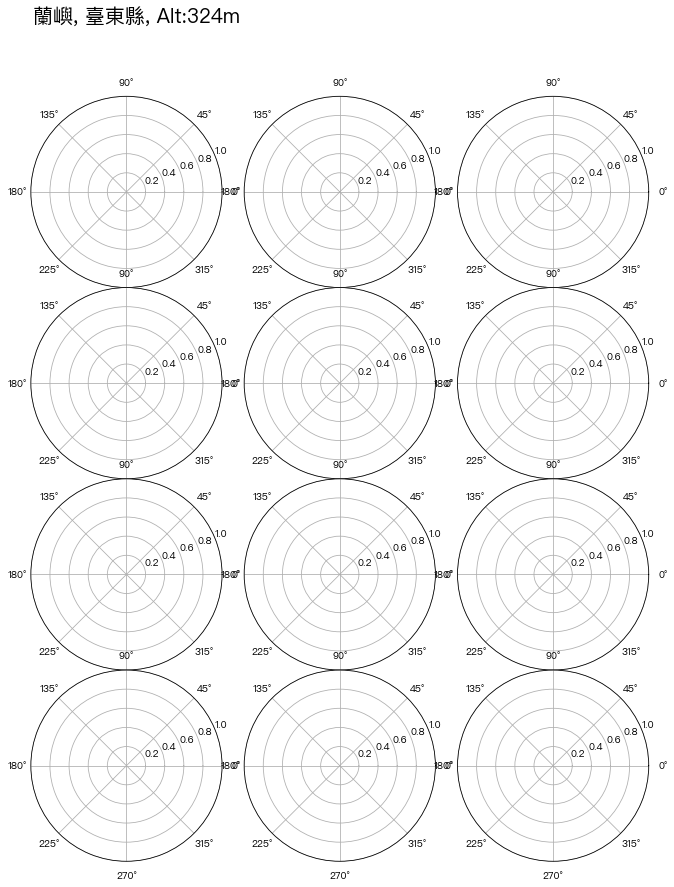

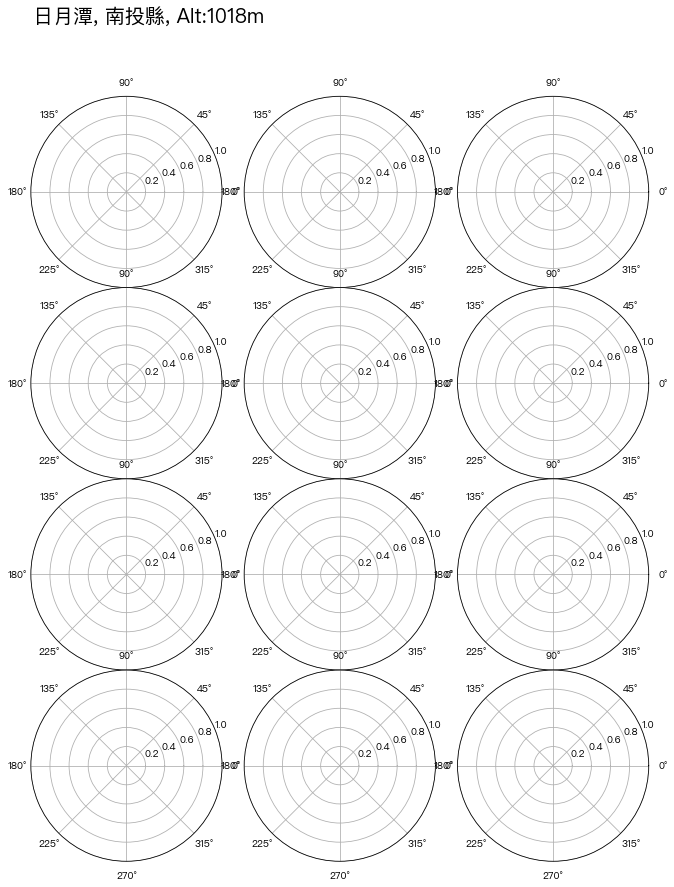

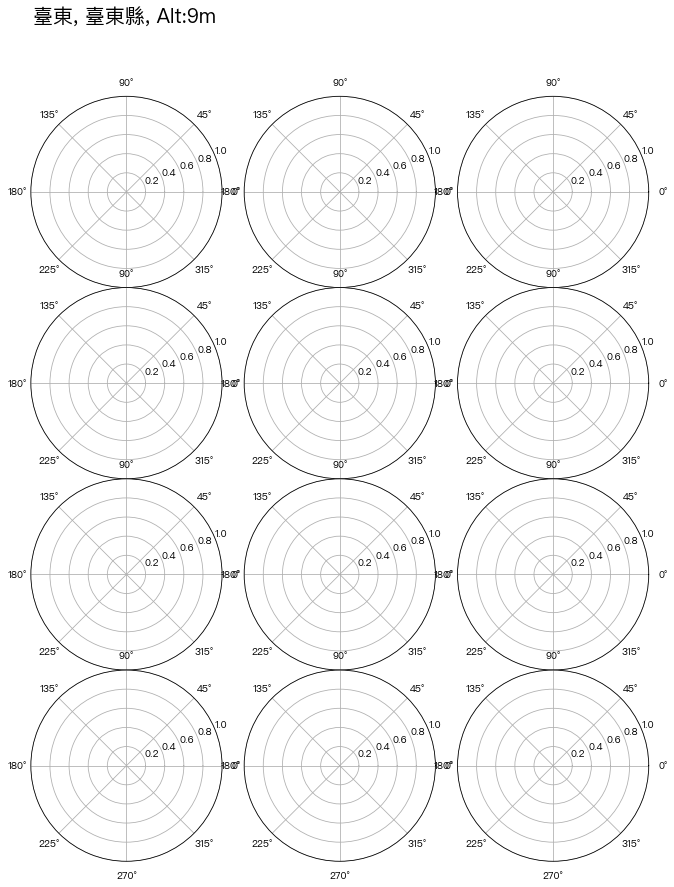

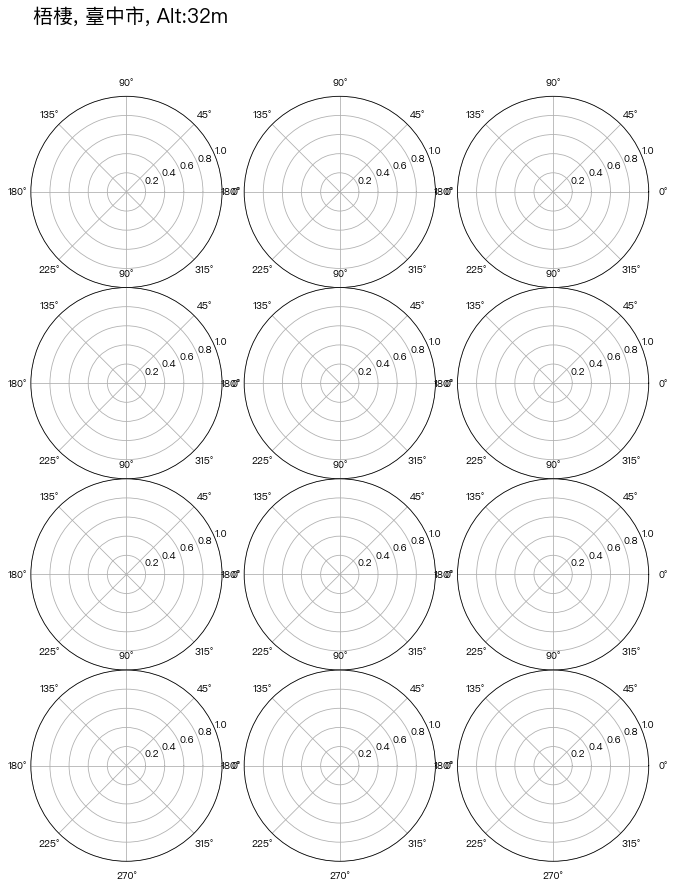

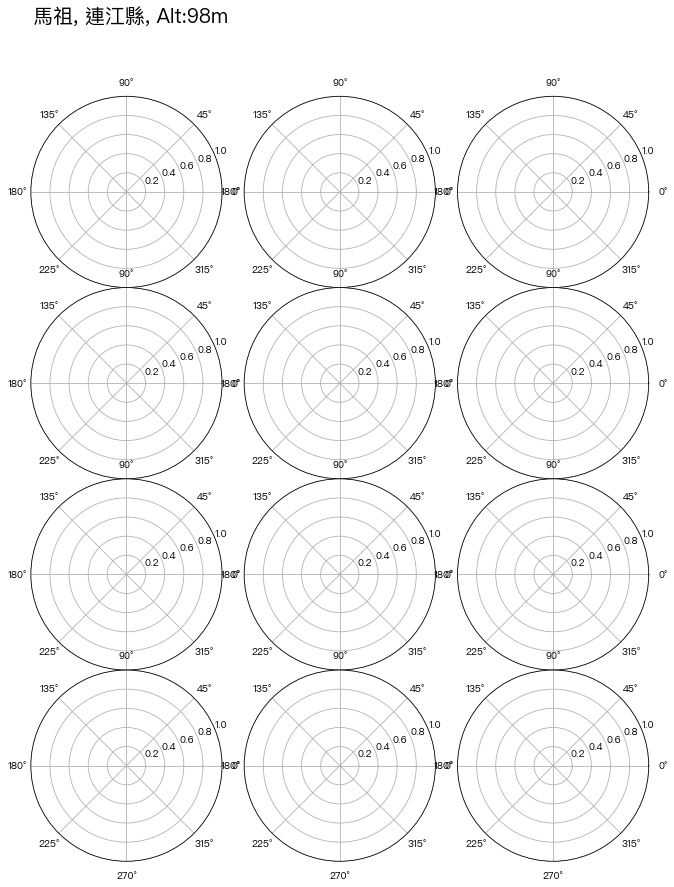

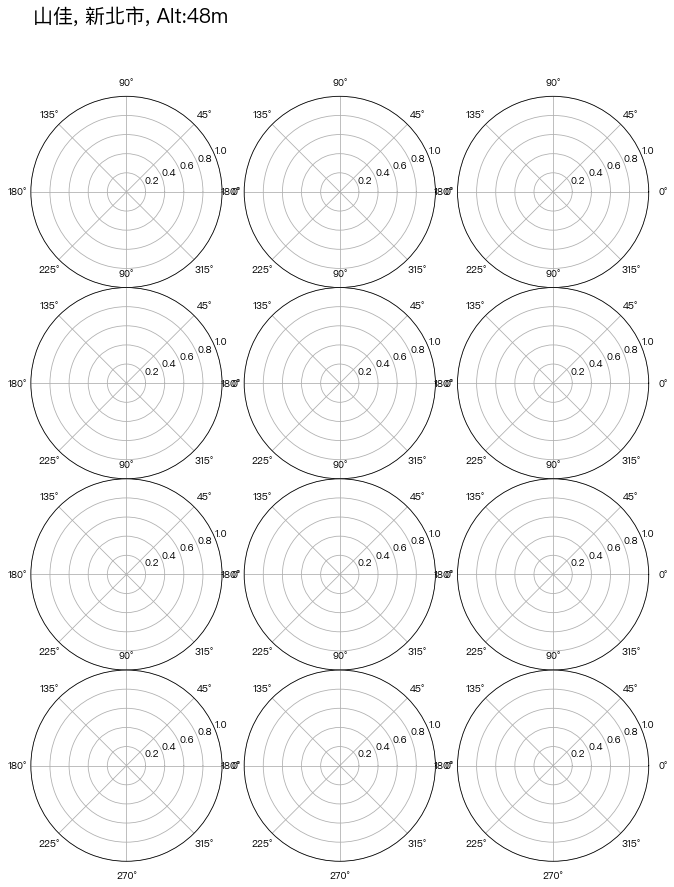

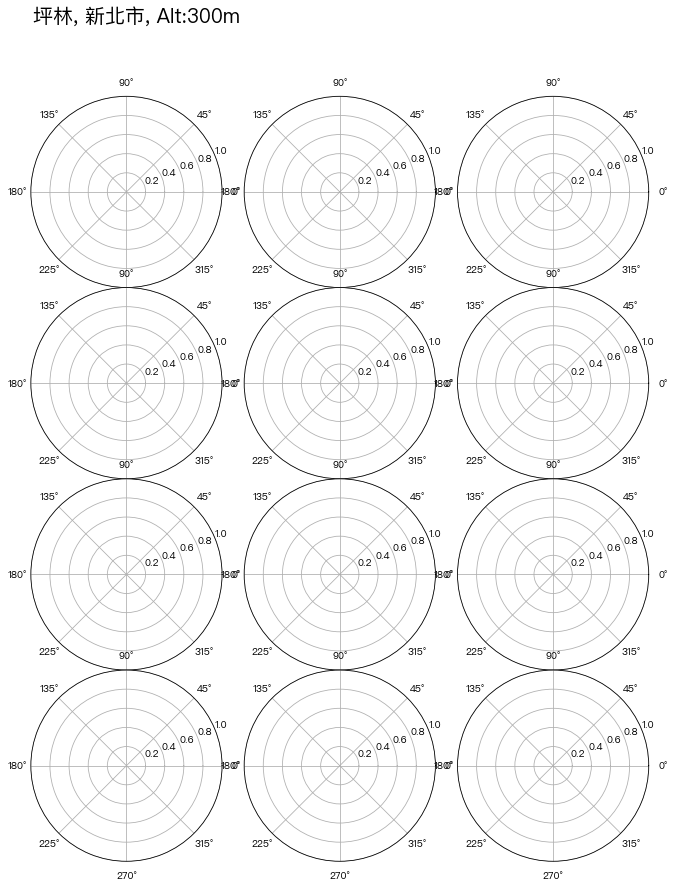

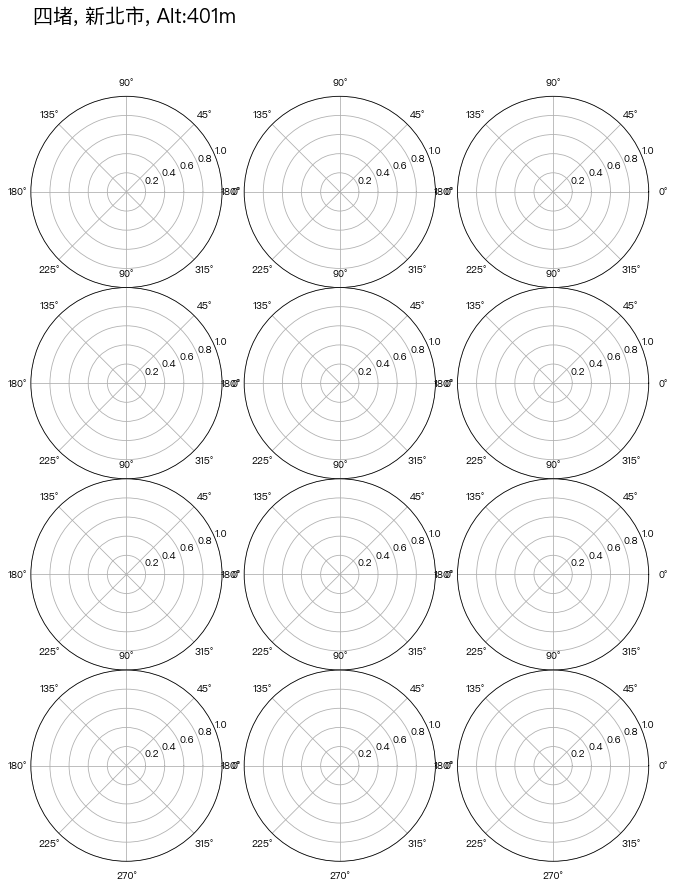

In [103]:
create_windrose_allstn(df, df_w, 'WD_bin_10', 'WS', save=True, cmap='Blues')

## Plot with multiprocessing

In [119]:
## function to split the dataframe into n_process
def chunk_df(df, n):
    size=int(df.shape[0]/n)
    chunks=[]
    for i in range(n): 
        if i < (n-1):
            chunks.append(df[i*size:(i+1)*size])
        else:
            chunks.append(df[i*size:])
    return chunks

In [120]:
import multiprocessing as mp
from functools import partial

ncpu = mp.cpu_count()
# ncpu=8
chunks = chunk_df(df, ncpu)
## make a partial function with parameters other than the chunked dataframe
fn = partial(create_windrose_allstn, df_weather=df_w, col_wd='WD_bin_10', col_ws='WS', save=True, cmap='Blues')

In [ ]:
%%time
p = mp.Pool(processes = ncpu)
p.map(fn, chunks)

## Plot map with wind stat image popup

In [60]:
from matplotlib import cm
import folium
import geocoder
import os
import base64


def map_with_windpopup(df, c_col, imagepath, cmap='Set1', location='Taiwan', zoom=9, jupyter=True):
    '''
    Create folium map with popup showing pre-generate images.
    Depending on whether the map need to be rendered in jupyter or in browser, 
    the way to embed image differs. In jupyter images need to be encoded in base64 
    string and save along the map html file. But for render in browser, the html
    link still works, and we don't need to embed images in html files but can be 
    loaded separately from img src="link".
    '''
    # create a color map
    ccode = df[c_col].astype('category').cat.codes
    cmap = cm.get_cmap(cmap, ccode.nunique())    # PiYG
    rgb = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
    
    # create the location map
    g = geocoder.osm(location)
    latitude = g.latlng[0]
    longitude = g.latlng[1]
    
    # create the main map
    f = folium.Figure(width=1200, height=900)
    map_ = folium.Map(location=[latitude, longitude], zoom_start=zoom).add_to(f)    
    
    # add marker to map
    for c,(i,row) in zip(ccode, df.iterrows()):
        hovertext = f'{row.stn_name}, {row.city}, Alt {row.altitude}m'
        Filename =os.path.join(imagepath, f'{row.stn_code}.png')
        html = '<body style="background-color:#E9E9E9;">'
#         html += f"<b>{row.stn_name}{row.stn_code}, 資料期間:{row.data_duration2}</b>"
        if os.path.isfile(Filename):
            if jupyter:
            ## embed the image as base64 string inside the html file
                encoded = base64.b64encode(open(Filename, 'rb').read())
                html+=f'<img src="data:image/png;base64,{encoded.decode("UTF-8")}" style="width:100%;height:100%;">'
                html=folium.IFrame(html, width=700, height=600)
#                 popup=folium.Popup(iframe, max_width='100%', autoPan=True, keepInView=True)
            else:
            # load the image in resources folder
                html += f'<br><img src="{Filename}" width="800">'
        else:
#             print(f'file not exist:{Filename}')
            pass
        popup=folium.Popup(html, max_width='100%', keepInView=True)
        
        folium.CircleMarker(
            [row.Latitude, row.Longitude],
            radius=5,
            popup=popup,
            tooltip=hovertext,
            color=rgb[c],
            fill=True,
            fill_color=rgb[c],
            fill_opacity=0.9,
            parse_html=False).add_to(map_)
#         print(i, row.stn_name)
    
    return map_

In [ ]:
map_weather = map_with_windpopup(df2, c_col='city', imagepath='resources', 
                                 cmap='tab10', location='Taiwan', zoom=8, jupyter=False)
map_weather

## Save map as html
change the leaflet popup background color by inserting an extraline using beautifulsoup...

In [62]:
map_weather.save('index.html')

In [63]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(open('index.html'), 'html.parser')
tag = soup.find_all('style')[-1]

tag.insert(0, ".leaflet-popup-content-wrapper {background-color: #E9E9E9}")

In [64]:
with open('index.html', "wb") as file:
    file.write(soup.prettify("utf-8"))